<img style="float: left;" src="resources/made.jpg" width="35%" height="35%">

# Академия MADE

# Семинар 7: Metric learning
Преподаватель: Эдуард Тянтов, руководитель направления машинного обучения в Почте и Портале Mail.ru.

В рамках семинара обучим модель распознавания лиц, используя несколько техник Metric Learning, на небольшом подмножестве MSCeleb.

Код написан на Python 3.7.
Для выполнения работы необходимы следующие пакеты:
* torch, torchvision (`conda install pytorch torchvision cudatoolkit=9.2 -c pytorch`)
* opencv, matplotlib (`conda install -c conda-forge opencv matplotlib`)
* pandas, jupyter (`conda install pandas jupyter`)
* faiss (`conda install -c pytorch faiss-cpu`)

## План
* смотрим на данные;
* обучаем сеть c Softmax;
* Center-loss;
* Arcface;
* оцениваем все 3 метода по валидации;
* тестируем на faiss/hnsw лучший из них.

In [3]:
!pip install -q faiss-gpu

     |████████████████████████████████| 89.4MB 52kB/s 


In [4]:
import datetime
import os
import time

import cv2
import faiss
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.backends.cudnn as cudnn
import torchvision.datasets
import torchvision.transforms as transforms
from torch import nn
from torch.nn import functional as F
from IPython.display import Image

from eval.lfw import test
from eval.loader import load_bin
from models.center_loss import CenterLoss
from models.resnet import resnet
from models.scoring import ArcFaceScoring
from utils import (
    AverageMeter,
    load_checkpoint,
    load_object,
    save_checkpoint,
    save_object,
)

In [5]:
print(torch.__version__)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}.")
num_devices = torch.cuda.device_count()
print(f"num_devices = {num_devices}")

NUM_WORKERS = 2

1.8.1+cu101
Using device: cuda.
num_devices = 1


In [6]:
data_path = "small_celeb"
test_data_path = "test_small_celeb"

pretrained_arc = "resources/arc_resnet18_512_16_epochs_checkpoint.pth.tar"
pretrained_softmax = "resources/softmax_resnet18_512_10_epochs_checkpoint.pth.tar"
pretrained_centerloss = "resources/centerloss_resnet18_512_10_epochs_checkpoint.pth.tar"
lfw_path = "resources/lfw.bin"  # lfw test dataset dump

assert os.path.exists(data_path)
assert os.path.exists(test_data_path)

## Данные
Давайте посмотрим, что из себя представляют данные из MSCeleb.
Датасет представляет из себя набор папок, в каждой папке — набор вырезанных лиц одного человека.
```
>$ ls small_celeb | head -5

100 
1000
10000
10001
10002
```
```
>$ ls small_celeb/100/100

2746.jpg  2747.jpg  2748.jpg  2749.jpg  2750.jpg  2751.jpg  2752.jpg
2753.jpg  2754.jpg  2755.jpg  2756.jpg  2757.jpg  2758.jpg  2759.jpg
2760.jpg  2761.jpg  2762.jpg  2763.jpg  2764.jpg
```

Давайте посмотрим, как выглядят данные по персонам.

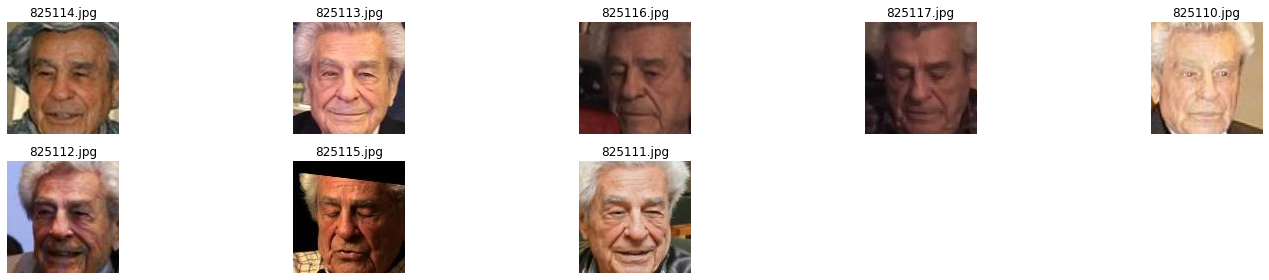

In [7]:
persons = os.listdir(data_path)
person = persons[np.random.randint(0, len(persons) - 1)]
person_folder = os.path.join(data_path, person, person)
files = os.listdir(person_folder)

SAMPLE_SIZE = len(files)
NUM_COLS = 5
NUM_ROWS = SAMPLE_SIZE // NUM_COLS + int(SAMPLE_SIZE % NUM_COLS != 0)
plt.figure(figsize=(20, 2 * NUM_ROWS))

for i, _file in enumerate(files):
    image = cv2.imread(os.path.join(person_folder, _file))
    text = _file
    plt.subplot(NUM_ROWS, NUM_COLS, i + 1)
    plt.imshow(image[:, :, ::-1])
    plt.title(text)
    plt.axis("off")

plt.tight_layout()
plt.show()

num_classes = len(persons)

## Тренировка

Сначала создадим датасет. Начнём с аугментаций.
Cutout — отличная аугментация, о которой вы, возможно, не знали.
Суть простая: зануляем пиксели в случайной области заданного размера, имитируя таким образом окклюзию.

In [8]:
class Cutout(object):
    """
    Аугментация, которая вырезает кусок заданного размера из картинки.
    https://arxiv.org/pdf/1708.04552.pdf
    """
    def __init__(self, size=8):
        self.size = size

    def __call__(self, tensor):
        _, h, w = tensor.shape
        y = np.random.randint(0, h)
        x = np.random.randint(0, w)
        tensor[:, y - self.size : y + self.size, x - self.size : x + self.size] = 0

        return tensor

Результат аугментации выглядит следующим образом:
<br>
<img style="float: left;" src="resources/cutout.png" width="35%" height="35%">
<br>
Зададим остальные преобразования:

In [9]:
# Inbuilt cudnn auto-tuner to find the best algorithm to use for your hardware:
if device == "cuda":
    cudnn.benchmark = True

normalize = transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])

train_transform = transforms.Compose(
    [
        # Вертикальный разворот не подойдет: если нужно распознавать такие фотографии,
        # то на детекторе надо предсказывать перевернутость головы, что может породить
        # ошибки на этапе инференса:
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        normalize,
        Cutout(size=14),  # по сути, имеем всего две аугментации
    ]
)

test_transform = transforms.Compose(
    [transforms.ToTensor(), normalize]
)  # на этапе инференса только нормализуем

# Используем стандартный датасет от PyTorch:
# the images are arranged in this way:
#         root/dog/xxx.png
#         root/dog/xxy.png
#         root/dog/xxz.png
#
#         root/cat/123.png
#         root/cat/nsdf3.png
#         root/cat/asd932_.png
train_dataset = torchvision.datasets.ImageFolder(data_path, train_transform)
test_dataset = torchvision.datasets.ImageFolder(test_data_path, test_transform)

print("The size of the train dataset:", len(train_dataset))
print("The size of the test dataset:", len(test_dataset))

# Зададим даталоадер:
batch_size = 160  # при значении 40 сеть при обучении займёт 3GB, при 160 — 10.5GB
train_sampler = None
train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=NUM_WORKERS,
    pin_memory=True,
    drop_last=True,
    sampler=train_sampler,
)

test_loader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=NUM_WORKERS,
    pin_memory=True,
    drop_last=False,
    sampler=train_sampler,
)

# Обратите внимание: shuffle и drop_last на инференсе — False.
# На что влиет num_workers? Как его подбирать? Как зависит от дисков?

The size of the train dataset: 50362
The size of the test dataset: 5080


Перейдём к различным функциям потерь.

Сначала обучим сеть с помощью софтмакса. Нам необходимо сделать небольшую модификацию линейного слоя, чтобы он всегда нормализовывал веса и входной тензор для того, чтобы работать на единичной сфере. Чем это удобно, кстати?

<img style="float: left;" src="resources/softmax_norm.jpg" width="35%" height="35%">

In [10]:
class LinearScoring(nn.Linear):
    def __init__(self, in_features, out_features):
        super(LinearScoring, self).__init__(in_features, out_features, bias=False)

    def forward(self, input, target=None):
        """The only difference is normalization of the input and weights."""
        input = F.normalize(input, p=2, dim=1)
        scores = F.linear(input, F.normalize(self.weight, p=2, dim=1))
        return scores

In [11]:
def init_arcface_scoring(emb_size, num_classes, m, s):
    scoring = ArcFaceScoring(
        m, s, in_features=emb_size, out_features=num_classes, device=device
    )
    criterion = nn.CrossEntropyLoss()
    return scoring, criterion


def init_softmax(emb_size, num_classes):
    scoring = LinearScoring(emb_size, num_classes)
    criterion = nn.CrossEntropyLoss()
    return scoring, criterion


def init_centerloss(emb_size, num_classes):
    scoring, criterion = init_softmax(emb_size, num_classes)
    center_loss = CenterLoss(num_classes, emb_size)
    return scoring, criterion, center_loss

In [12]:
# Parameters:
center_loss, optimzer4center = None, None
cl_loss_weight = 5e-3  # вес при лоссе относительно CE
head_size = 7 * 7 * 512  # size of the last resnet layer's output
emb_size = 512
lr, center_lr = 0.01, 0.1
momentum = 0.9
weight_decay = 5e-4

# Init scoring:
# scoring, criterion = init_arcface_scoring(emb_size, num_classes, m=0.5, s=64.0)
scoring, criterion = init_softmax(emb_size, num_classes)
# scoring, criterion, center_loss = init_centerloss(emb_size, num_classes)

# Создадим модель и оптимизатор:
model = resnet(18, num_classes, emb_size=emb_size, scoring=scoring, head_size=head_size)

# model = torch.nn.parallel.DataParallel(model.to(device))
model = model.to(device)
criterion = criterion.to(device)

optimizer = torch.optim.SGD(
    model.parameters(), lr, momentum=momentum, weight_decay=weight_decay
)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, patience=2, verbose=True
)

if center_loss is not None:
    center_loss = center_loss.to(device)
    optimzer4center = torch.optim.SGD(center_loss.parameters(), lr=center_lr)

# TODO: change lr over time scheduler
# <see models/resnet.py>
print(model)

ResNet(
  (body): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): PReLU(num_parameters=1)
  )
  (layer1): Sequential(
    (0): BasicBlockV3(
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (activation): PReLU(num_parameters=1)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (downsample): Sequential(
        (0): Conv2d(64, 64, kernel_size=(1, 1), stride=(2, 2), bias=False)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  

## Валидация
Валидироваться будем на стандартном небольшом датасете LFW (http://vis-www.cs.umass.edu/lfw/).
У нас есть список пар фотографий и список соответствий [issame_list](https://github.com/Illumaria/made-computer-vision/blob/master/07-metric-learning/eval/lfw.py#L224):
в `issame_list` хранится информация о том, являются ли два лица из пары одним и тем же человеком или нет.

Мы находим эмбеддинг для лица (прогоняем два раза для лица и отзеркаленного лица и усредням), далее для разных пороговых значений проверяем, что два заданных лица одного и того же человека считаются нашей сеткой одной парой ([lfw.py#L157](https://github.com/Illumaria/made-computer-vision/blob/master/07-metric-learning/eval/lfw.py#L157)).

Обученные модели на этом датасете выбивают примерно 99.7.

In [13]:
# Validate:
val_set = load_bin(lfw_path, (112, 112))

/content/drive/MyDrive/Colab Notebooks/MADE/cv07/metric_learning/resources/lfw.bin
loading bin 1000
loading bin 2000
loading bin 3000
loading bin 4000
loading bin 5000
loading bin 6000
loading bin 7000
loading bin 8000
loading bin 9000
loading bin 10000
loading bin 11000
loading bin 12000
(12000, 3, 112, 112)


In [14]:
# Traning routine:
if torch.cuda.is_available():
    torch.cuda.empty_cache()


def train(
    train_loader, model, criterion, optimizer, epoch, start_epoch, print_freq=100
):
    batch_time = AverageMeter()
    data_time = AverageMeter()
    avg_loss = AverageMeter()

    end = time.time()
    for i, (input, target) in enumerate(train_loader):
        data_time.update(time.time() - end)
        input = input.to(device)
        target = target.to(device)

        emb, scores, losses = model(input, target)
        loss = criterion(scores, target)

        if center_loss is not None:
            cl_loss = center_loss(target, emb)
            loss += cl_loss.sum() * cl_loss_weight
            optimzer4center.zero_grad()

        avg_loss.update(loss.item(), input.size(0))

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if optimzer4center is not None:
            optimzer4center.step()
        batch_time.update(time.time() - end)
        end = time.time()

        if i % print_freq == 0:
            line = (
                "Epoch: [{0}][{1}/{2}]\t"
                "Time {batch_time.val:.3f} ({batch_time.avg:.3f})\t"
                "Data time {data_time.val:.3f} ({data_time.avg:.3f})\t"
                "Loss {loss.val:.4f} ({loss.avg:.4f})\t".format(
                    epoch,
                    i + start_epoch,
                    len(train_loader),
                    batch_time=batch_time,
                    data_time=data_time,
                    loss=avg_loss,
                )
            )
            print(line)


# Train:
start_epoch, epoch_duration, best_prec1 = 0, 0, 0
num_epochs = 0

checkpoint_path = "checkpoints/"
if not os.path.exists(checkpoint_path):
    os.mkdir(checkpoint_path)

model.train()
for epoch in range(start_epoch, num_epochs):
    start_time = datetime.datetime.now()
    print("Previous epoch duration: %s" % epoch_duration)
    print("Current epoch start time:", start_time)

    train(train_loader, model, criterion, optimizer, epoch, start_epoch)
    # Validate:
    acc1, std1, prec1, std2, _xnorm, embeddings_list = test(
        val_set, model, batch_size, device=device
    )
    print("val lfw acc %1.5f+-%1.5f , acc2 %1.5f+-%1.5f \n" % (acc1, std1, prec1, std2))

    scheduler.step(prec1)

    end_time = datetime.datetime.now()
    epoch_duration = end_time - start_time

    # Save:
    is_best = prec1 > best_prec1
    best_prec1 = max(prec1, best_prec1)
    save_checkpoint(
        {
            "epoch": epoch + 1,
            "arch": "resnet18",
            "state_dict": model.state_dict(),
            "best_prec1": best_prec1,
            "optimizer": optimizer.state_dict(),
        },
        is_best,
        os.path.join(checkpoint_path, "checkpoint"),
    )

print("Training ended, best pre1", best_prec1)

Training ended, best pre1 0


Провалидируем модель:

In [15]:
LOAD = True
torch.cuda.empty_cache()

if LOAD:
    print("Loading trained for 10 epochs model")
    if isinstance(model.scoring, ArcFaceScoring):
        load_checkpoint(model, pretrained_arc)
        print(open("resources/arcface_train_log.txt", "r").read())
    elif center_loss is not None:
        load_checkpoint(model, pretrained_centerloss)
        print(open("resources/centerloss_train_log.txt", "r").read())
    else:
        load_checkpoint(model, pretrained_softmax)
        print(open("resources/softmax_train_log.txt", "r").read())
else:
    load_checkpoint(model, os.path.join(checkpoint_path, "checkpoint_best.pth.tar"))

acc1, std1, prec1, std2, _xnorm, embeddings_list = test(
    val_set, model, batch_size, device=device
)
print("lfw acc %1.5f+-%1.5f , acc2 %1.5f+-%1.5f" % (acc1, std1, prec1, std2))

Loading trained for 10 epochs model
=> loaded checkpoint '/content/drive/MyDrive/Colab Notebooks/MADE/cv07/metric_learning/resources/softmax_resnet18_512_10_epochs_checkpoint.pth.tar' (epoch 7) (score 0.8561666666666665)
Previous epoch duration: 0
Current epoch start time: 2020-04-30 15:11:22.579547
Epoch: [0][0/314]	Time 1.097 (1.097)	Data time 0.688 (0.688)	Loss 7.1086 (7.1086)	
Epoch: [0][100/314]	Time 0.399 (0.401)	Data time 0.000 (0.007)	Loss 7.0542 (7.0829)	
Epoch: [0][200/314]	Time 0.396 (0.399)	Data time 0.000 (0.004)	Loss 7.0311 (7.0627)	
Epoch: [0][300/314]	Time 0.414 (0.399)	Data time 0.000 (0.003)	Loss 6.9986 (7.0468)	
testing lfw..
val lfw acc 0.76917+-0.01606 , acc2 0.76600+-0.01576 

Previous epoch duration: 0:02:30.485903
Current epoch start time: 2020-04-30 15:13:56.003754
Epoch: [1][0/314]	Time 1.098 (1.098)	Data time 0.707 (0.707)	Loss 6.9730 (6.9730)	
Epoch: [1][100/314]	Time 0.389 (0.393)	Data time 0.000 (0.007)	Loss 6.9432 (6.9595)	
Epoch: [1][200/314]	Time 0.382 

Разумный максимум в виде значения 99.7 годится для замеров на небольшом датасете.

Для больших датасетов оценка вырастает до максимального значения и дальше шумит. Нужно использовать другую, более трудную валидацию — например, Megaface.

## Center loss
Посмотрим на Center loss. Идея:

<img style="float: left;" src="resources/center_loss_idea.png" width="100%" height="100%">

По сути мы используем два лосса:
 - дискриминационный (softmax), чтобы обеспечить разделяемость;
 - стягивающий для компактности (center loss).

<img style="float: left;" src="resources/center_loss_arch.png" width="100%" height="100%">

In [16]:
# <see models/scoring.py>

В Backprop вычисляется вот эта формула, хотя, строго говоря, можно было доверить её вычисление автограду:

<img style="float: left;" src="resources/center_loss_grad.png" width="40%" height="40%">

## Arcface

Перейдём к Arcface. Основная идея A-Softmax лоссов — оперировать на единичной окружности, где за разделимость отвечает угол между векторами (весами линейного слоя) классов.

<img style="float: left;" src="resources/arcface_idea.png" width="100%" height="100%">

Для этого мы усложняем задачу модели для элементов одного класса, занижая скор по формуле:

<img style="float: left;" src="resources/arcface_reduce.png" width="100%" height="100%">
<img style="float: left;" src="resources/arcface_formula.png" width="100%" height="100%">

In [17]:
# <see models/scoring.py>

## Search indices

Рассмотрим HNSW и Faiss.

Для начала вычислим тестовые эмбеддинги:

In [18]:
# Compute embeddings for test set:
model.eval()

img_label_list = test_loader.dataset.imgs  # img names & labels
embeddings = np.zeros((len(img_label_list), emb_size), dtype=np.float32)
targets = np.array([w[1] for w in img_label_list])
with torch.no_grad():
    for i, (input, target) in enumerate(test_loader):
        input = input.to(device)
        embed, _, _ = model(input, target=None, calc_scores=False)
        embed = embed.to("cpu").numpy()  # shape batch_size x emb_size
        embeddings[i * batch_size : (i + 1) * batch_size, :] = embed
print("Test_embeddings are ready", embeddings.shape)

Test_embeddings are ready (5080, 512)


Поскольку индексы AKNN предназначены для больших данных (иначе можно перебором всё делать), то было использовано 200_000 картинок из MSceleb (не из трейна), чтобы на них посмотреть, какие у нас получатся метрики, и поиграться с параметрами индексов.
При эксперименте использовалась модель Arcface, которая загружается выше.

In [19]:
BIG_INDEX_ON = True

# Load bigger numbers:
if BIG_INDEX_ON:
    embeddings, targets = load_object("resources/msceleb_emb.dump")
    img_label_list = load_object("resources/msceleb_names.dump")

# Exclude M photos of each person:
M = 1
prev, cnt = -1, 0
masks = np.zeros((embeddings.shape[0],), dtype=np.bool)
for i, v in enumerate(targets):
    is_test = v != prev and cnt < M
    masks[i] = is_test
    if is_test:
        cnt += 1
    else:
        prev, cnt = v, 0

train_embeddings, train_targets = (
    embeddings[np.invert(masks)],
    targets[np.invert(masks)],
)
test_embeddings, test_targets = embeddings[masks], targets[masks]

print(
    "Shape of embeddings total/train/test",
    embeddings.shape,
    train_embeddings.shape,
    test_embeddings.shape,
)

Shape of embeddings total/train/test (200000, 512) (195130, 512) (4870, 512)


### Faiss

<img style="float: left;" src="resources/faiss_ivf.png" width="100%" height="100%">
Два основных параметра, которыми мы рулим:

- кол-во центройдов. Определяет на сколько частей мы бьем наше пространство
* если их мало, то будет долгий поиск, т.к. почти фулл скан нужно сделать
- чем больше центройдов, тем дольше строить индекс
- nprobes - кол-во проб (т.е. поисков по центройдам), при =1 берем только самый ближайший, но тогда будет низкая точность AKNN
 * линейно зависит время поиска

In [20]:
# Будем мерить rank1 и засекать время:
def evaluate(_index, test_embeddings):
    start = time.time()
    distances, items = _index.search(test_embeddings, 1)
    print("Timing", time.time() - start)

    scores = []
    for i in range(items.shape[0]):
        closest_idx, closest_dist = items[i, 0], distances[i, 0]
        scores.append(int(test_targets[i] == train_targets[closest_idx]))
    rank1 = sum(scores) / items.shape[0]
    print("Rank1", rank1)
    return rank1

In [21]:
num_centroids = 32  # 32 is enough, more is more expensive
faiss_algo = "IVF%d,Flat" % (num_centroids,)  # inverted files with so many centroids
print("Сreate faiss index")
index = faiss.index_factory(emb_size, faiss_algo)
index.verbose = True


# Training. По сути тренируем центроиды и Product Quantizer:
print("train", train_embeddings.shape, train_embeddings.dtype)
assert not index.is_trained
start = time.time()
index.train(train_embeddings)
print("Construction done", time.time() - start)

# А теперь загружаем данные в индекс. Eсли будем добавлять новые данные, не факт,
# что обученные параметры будут эффективно искать по ним.
# Но если распределение не меняется, то перетренировывать его не надо.
print("Add data to index")
index.add(train_embeddings)
ps = faiss.ParameterSpace()
ps.initialize(index)
index.search_type = faiss.IndexPQ.ST_PQ  # устанавливаем тип индекса с квантизацией
print("Ready to query")

Сreate faiss index
train (195130, 512) float32
Construction done 0.24090886116027832
Add data to index
Ready to query


Сначала запустим фуллскан, чтобы понять, какой `rank1` максимальный:

In [22]:
# Так как это обычный фуллскан, то "тренировки" нет:
index_f = faiss.IndexFlatL2(emb_size)
index_f.add(train_embeddings)
evaluate(index_f, test_embeddings)

Timing 14.812952756881714
Rank1 0.3568788501026694


0.3568788501026694

In [23]:
index.nprobe = 5  # 1 — bad, 5 — ok
print("IVF, Num_centroids", num_centroids, "probes", index.nprobe)
evaluate(index, test_embeddings)

IVF, Num_centroids 32 probes 5
Timing 59.82523250579834
Rank1 0.3484599589322382


0.3484599589322382

### HNSW

<img style="float: left;" src="resources/hnsw.png" width="50%" height="50%">

Напомню, что алгоритм графовый, иерархичный. Основан на тесном мире.
Что важно:

- при построении индекса необходимо, чтобы элементы сэмплировались случайно:
 * самые длинные рёбра образуются на первых итерациях. Они позволяют быстро перемещаться по графу. Если семлировать из кластеров, то длинных рёбер не будет;
- построение: векторное представление добавляем в граф, чем больше efConstruction (длина списка), тем точнее вставляем в граф;
 * из этого списка мы ищем M лучших соседей и проводим M рёбер;
- efSearch: количество элементов в списке минимальных обнаруженных дистанций. В нём хранятся упорядоченные дистанции. Наибольшие дистанции вытесняются. В тот момент, когда список не обновился, мы считаем, что нашли ближайшего соседа.


In [24]:
index_h = faiss.IndexHNSWFlat(emb_size, 32)

# Длина списка во время построения:
index_h.hnsw.efConstruction = 32  # 40 - is enough

start = time.time()
index_h.verbose = True
index_h.add(train_embeddings)
print("Construction HNSW done", time.time() - start)

Construction HNSW done 281.4670293331146


In [25]:
# Длина списка во время поиска:
index_h.hnsw.efSearch = 8  # 32 almost
print(
    "HNSW, efConstruction=%d, efSearch=%d"
    % (index_h.hnsw.efConstruction, index_h.hnsw.efSearch)
)
evaluate(index_h, test_embeddings)

HNSW, efConstruction=32, efSearch=8
Timing 0.9870023727416992
Rank1 0.28706365503080084


0.28706365503080084

Сравнение на миллионе:
https://github.com/facebookresearch/faiss/wiki/Indexing-1M-vectors
<img style="float: left;" src="resources/index_comp.png" width="100%" height="100%">

